In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import numpy as np
import pymc as pm
import pytensor.tensor as pt

import pytensor

from pymc.model.fgraph import fgraph_from_model, model_from_fgraph

In [3]:
def marginalize(
    model,
    rvs_to_marginalize,
    Q,
    temp_kwargs,
    minimizer_kwargs={"method": "BFGS", "optimizer_kwargs": {"tol": 1e-8}},
):
    from pymc.model.fgraph import (
        ModelFreeRV,
        ModelValuedVar,
    )

    from pymc_extras.model.marginal.graph_analysis import (
        find_conditional_dependent_rvs,
        find_conditional_input_rvs,
        is_conditional_dependent,
        subgraph_batch_dim_connection,
    )

    from pymc_extras.model.marginal.marginal_model import (
        _unique,
        collect_shared_vars,
        remove_model_vars,
    )

    from pymc_extras.model.marginal.distributions import (
        MarginalLaplaceRV,
    )

    from pymc.pytensorf import collect_default_updates

    from pytensor.graph import (
        FunctionGraph,
        Variable,
        clone_replace,
    )

    fg, memo = fgraph_from_model(model)
    rvs_to_marginalize = [memo[rv] for rv in rvs_to_marginalize]
    toposort = fg.toposort()

    for rv_to_marginalize in sorted(
        rvs_to_marginalize,
        key=lambda rv: toposort.index(rv.owner),
        reverse=True,
    ):
        all_rvs = [node.out for node in fg.toposort() if isinstance(node.op, ModelValuedVar)]

        dependent_rvs = find_conditional_dependent_rvs(rv_to_marginalize, all_rvs)
        if not dependent_rvs:
            # TODO: This should at most be a warning, not an error
            raise ValueError(f"No RVs depend on marginalized RV {rv_to_marginalize}")

        # Issue warning for IntervalTransform on dependent RVs
        for dependent_rv in dependent_rvs:
            transform = dependent_rv.owner.op.transform

            # if isinstance(transform, IntervalTransform) or (
            #     isinstance(transform, Chain)
            #     and any(isinstance(tr, IntervalTransform) for tr in transform.transform_list)
            # ):
            #     warnings.warn(
            #         f"The transform {transform} for the variable {dependent_rv}, which depends on the "
            #         f"marginalized {rv_to_marginalize} may no longer work if bounds depended on other variables.",
            #         UserWarning,
            #     )

        # Check that no deterministics or potentials depend on the rv to marginalize
        for det in model.deterministics:
            if is_conditional_dependent(memo[det], rv_to_marginalize, all_rvs):
                raise NotImplementedError(
                    f"Cannot marginalize {rv_to_marginalize} due to dependent Deterministic {det}"
                )
        for pot in model.potentials:
            if is_conditional_dependent(memo[pot], rv_to_marginalize, all_rvs):
                raise NotImplementedError(
                    f"Cannot marginalize {rv_to_marginalize} due to dependent Potential {pot}"
                )

        marginalized_rv_input_rvs = find_conditional_input_rvs([rv_to_marginalize], all_rvs)
        other_direct_rv_ancestors = [
            rv
            for rv in find_conditional_input_rvs(dependent_rvs, all_rvs)
            if rv is not rv_to_marginalize
        ]
        input_rvs = _unique((*marginalized_rv_input_rvs, *other_direct_rv_ancestors))

        output_rvs = [rv_to_marginalize, *dependent_rvs]
        rng_updates = collect_default_updates(output_rvs, inputs=input_rvs, must_be_shared=False)
        outputs = output_rvs + list(rng_updates.values())
        inputs = input_rvs + list(rng_updates.keys())
        # Add any other shared variable inputs
        inputs += collect_shared_vars(output_rvs, blockers=inputs)

        inner_inputs = [inp.clone() for inp in inputs]
        inner_outputs = clone_replace(outputs, replace=dict(zip(inputs, inner_inputs)))
        inner_outputs = remove_model_vars(inner_outputs)

        marginalize_constructor = MarginalLaplaceRV

        _, _, *dims = rv_to_marginalize.owner.inputs
        marginalization_op = marginalize_constructor(
            inputs=inner_inputs,
            outputs=inner_outputs,
            dims_connections=[
                (None,),
            ],  # dependent_rvs_dim_connections, # TODO NOT SURE WHAT THIS IS
            dims=dims,
            Q=Q,
            temp_kwargs=temp_kwargs,
            minimizer_kwargs=minimizer_kwargs,
        )

        new_outputs = marginalization_op(*inputs)
        for old_output, new_output in zip(outputs, new_outputs):
            new_output.name = old_output.name

        model_replacements = []
        for old_output, new_output in zip(outputs, new_outputs):
            if old_output is rv_to_marginalize or not isinstance(
                old_output.owner.op, ModelValuedVar
            ):
                # Replace the marginalized ModelFreeRV (or non model-variables) themselves
                var_to_replace = old_output
            else:
                # Replace the underlying RV, keeping the same value, transform and dims
                var_to_replace = old_output.owner.inputs[0]
            model_replacements.append((var_to_replace, new_output))

        fg.replace_all(model_replacements)

    return model_from_fgraph(fg, mutate_fgraph=True)

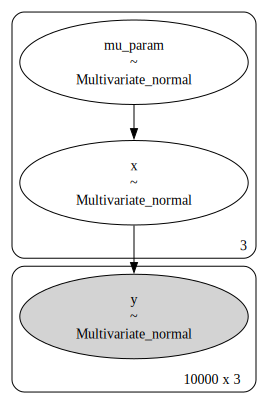

In [5]:
rng = np.random.default_rng(12345)
n = 10000
d = 3

mu_mu = np.zeros((d,))
mu_true = np.ones((d,))

cov = np.diag(np.ones(d))
Q_val = np.diag(np.ones(d))
cov_true = np.diag(np.ones(d))

with pm.Model() as model:
    x_mu = pm.MvNormal("mu_param", mu=mu_mu, cov=cov)

    x = pm.MvNormal("x", mu=x_mu, tau=Q_val)

    y_obs = rng.multivariate_normal(mean=mu_true, cov=cov_true, size=n)

    y = pm.MvNormal(
        "y",
        mu=x,
        cov=cov,
        observed=y_obs,
    )

pm.model_to_graphviz(model)

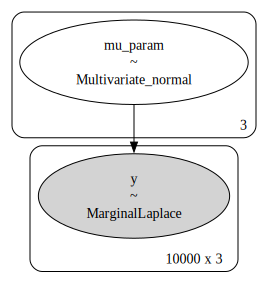

In [14]:
model_marg = marginalize(
    model,
    [x],
    Q=Q_val,
    temp_kwargs=None,
    minimizer_kwargs={"method": "L-BFGS-B", "optimizer_kwargs": {"tol": 1e-8}},
)
pm.model_to_graphviz(model_marg, var_names=["y"])

In [15]:
rng = np.random.default_rng(12345)
mu = rng.random(d)

f_logp = model_marg.compile_logp(profile=True)

In [16]:
%%timeit
f_logp({"mu_param": mu})

9.58 ms ± 428 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
f_logp.f.profile.summary()

Function profiling
  Message: /home/michaln/git/pymc/pymc/pytensorf.py:942
  Time in 811 calls to Function.__call__: 7.819569e+00s
  Time in Function.vm.__call__: 7.7988263611114235s (99.735%)
  Time in thunks: 7.780319690704346s (99.498%)
  Total compilation time: 6.888381e-01s
    Number of Apply nodes: 29
    PyTensor rewrite time: 3.427114e-01s
       PyTensor validate time: 5.761475e-03s
    PyTensor Linker time (includes C, CUDA code generation/compiling): 0.3434671189970686s
       C-cache preloading 5.671625e-03s
       Import time 0.000000e+00s
       Node make_thunk time 3.368705e-01s
           Node MinimizeOp(method=L-BFGS-B, jac=True, hess=False, hessp=False)([0.2273360 ... .79736546], True, [0.], [[2]], [[[1. 0. 0 ... . 0. 1.]]], [0.5], True, 0.0, [[2]], ExpandDims{axis=0}.0, [[[1. 0. 0 ... . 0. 1.]]]) time 2.206649e-01s
           Node Scan{scan_fn, while_loop=False, inplace=none}(3, [0 1 2], 3, Neg.0, Neg.0) time 1.019020e-01s
           Node Squeeze{axis=0}(CAReduce{Co